In [215]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png")

In [216]:
import numpy as np
import os

# Seed random variables for reproducibility
os.environ['PYTHONHASHSEED'] = '1974'
np.random.seed(0)

# Functions

Below we explore the non-linear activation functions used in vanilla implementations of LSTMs. For an extensive list of activation functions and their forumlae there is an excellent table at https://en.wikipedia.org/wiki/Activation_function.

## Sigmoid

The logistic sigmoid function has a mean, $\mu$ of 0 and std. dev. of 1.

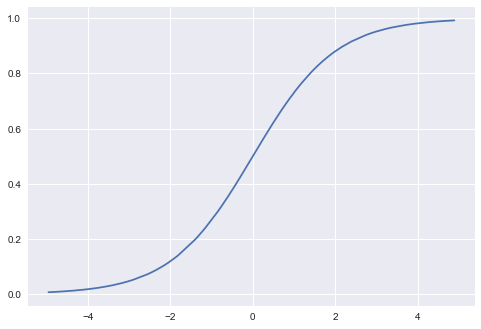

In [217]:
import numpy as np
from matplotlib import pyplot as plt

def sigmoid(x):
    return 1/(1 + np.exp(-x))

xs = sorted(np.random.uniform(-5, 5, size=100))
ys = [sigmoid(x) for x in xs]
plt.plot(xs, ys)
plt.show()

## Tanh

Hyperbolic tangent function has a range (-1, 1) with a mean, $\mu$ of 0.

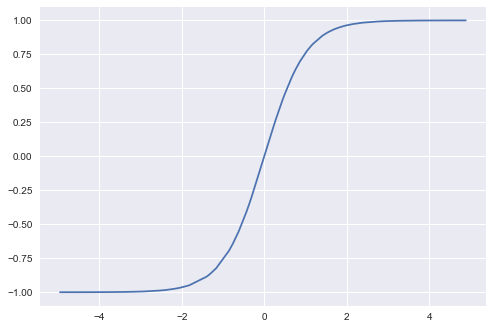

In [218]:
def tanh(x):
    return 2/(1 + np.exp(-2*x)) - 1

ys = [tanh(x) for x in xs]
plt.plot(xs, ys)
plt.show()

# Hyperparameters

These are parameters that we will tune using distributed methods later, right now think of them as arbitrary values that define the shape of our network.

In [243]:
embedding_dim = 3
hidden_dim = 4

# Parameters

In [220]:
sentence = "The quick brown fox jumps over the lazy dog"
#sentence = "All A B"
tokens = sentence.split(" ")

def initialize_parameters():
    word_embedding = np.random.rand(1, embedding_dim)
    prev_hidden_state = np.random.rand(1, hidden_dim)
    cell_state = np.random.rand(1, hidden_dim)
    bias = np.zeros(1)
    
    return {"word_embedding": word_embedding, "prev_hidden_state": prev_hidden_state,
            "cell_state": cell_state, "bias": bias}

params = initialize_parameters()
print(params["word_embedding"])
print(params["prev_hidden_state"])
print(params["cell_state"])

[[ 0.67781654  0.27000797  0.73519402]]
[[ 0.96218855  0.24875314  0.57615733  0.59204193]]
[[ 0.57225191  0.22308163  0.95274901  0.44712538]]


# LSTM
## Forget gate

$f_t = $ 

In [221]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png", width=1000, height=1000)

In [222]:
W_f = np.random.randn(hidden_dim, hidden_dim + embedding_dim)
b_f = np.zeros(1)

In [244]:
_input = np.concatenate((params["word_embedding"], params["prev_hidden_state"]), axis=1)

def forget_gate(_input):
    # Compute forget gate via sigmoid function on affine map of input
    # make use of python broadcasting to add the bias vector across all vectors of the weighted input matrix
    forget_mask = sigmoid(np.dot(W_f, _input.T) + b_f)
    return forget_mask.T

## Ignore Gate

In [245]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png", width=1000, height=1000)

In [246]:
W_i = np.random.randn(hidden_dim, hidden_dim + embedding_dim)
b_i = np.zeros(1)

W_c = np.random.randn(hidden_dim, hidden_dim + embedding_dim)
b_c = np.zeros(1)

In [247]:
def input_gate(_input):
    i = sigmoid(np.dot(W_i, _input.T) + b_i)
    c = tanh(np.dot(W_c, _input.T) + b_c)
    return (i * c).T

In [248]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png", width=1000, height=1000)

In [249]:
params["cell_state"] = forget_gate(_input) * params["cell_state"] + input_gate(_input)

In [250]:
params["cell_state"]

array([[ 0.31791415, -0.47202775, -0.05245668, -0.35293658]])

In [251]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png", width=1000, height=1000)

In [252]:
# Initialize weights
W_o = np.random.randn(hidden_dim, hidden_dim + embedding_dim)
b_o = np.zeros(1)

In [253]:
def output_gate(_input):
    output_mask = sigmoid(np.dot(W_o, _input.T) + b_o)
    return output_mask.T

In [258]:
params["hidden_state"] = output_gate(_input) * tanh(params["cell_state"])

In [261]:
lstm_output = []
lstm_output.append(params["hidden_state"])